In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
import logging
import os
import time
import matplotlib

import numpy as np
import matplotlib.pyplot as plt
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim as optim
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

from lib.dataset_utils import *
from lib.mnist_model import *
from lib.custom_layers import *
from lib.ibp_layers import *

In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [4]:
def get_input_bound(x, eps):
    x_ub = torch.clamp(x + eps, 0, 1)
    x_lb = torch.clamp(x - eps, 0, 1)
    return x, x_ub, x_lb

In [20]:
exp = 8
model_name = 'mnist_linf_ibp_exp%d.h5' % exp

# net = IBPMedium()

params = {'p': 2,
          'epsilon': 1.5,
          'input_bound': (0, 1)}
net = IBPSmallCustom(LpLinear, params)

In [21]:
# Set all random seeds
seed = 2019
np.random.seed(seed)
torch.manual_seed(seed)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Set up model directory
save_dir = os.path.join(os.getcwd(), 'saved_models/')
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)

net = net.to(device)
# if device == 'cuda':
#     net = torch.nn.DataParallel(net)
#     cudnn.benchmark = True
net.load_state_dict(torch.load(model_path))
# net = net.module
# net = net.basic_net
net.eval()

IBPSmallCustom(
  (fc1): LpLinear(in_features=784, out_features=2000, bias=True)
  (relu1): IBPReLU()
  (fc2): IBPLinear()
  (relu2): IBPReLU()
  (fc3): IBPLinear()
  (relu3): IBPReLU()
  (fc4): IBPLinear()
)

In [7]:
(x_train, y_train), _, (x_test, y_test) = load_mnist_all(
    '/data', val_size=0, seed=seed)

In [25]:
eps = 1
params = {'p': 2,
          'epsilon': eps,
          'input_bound': (0, 1)}

with torch.no_grad():
    out = net.get_activations(x_test.cuda(), params)
    diff = net.get_bound(x_test.cuda(), y_test.cuda(), params)

In [26]:
(diff >= 0).float().mean()

tensor(0.6799, device='cuda:0')

In [24]:
(out[-1][0].argmax(1).cpu() == y_test).float().mean()

tensor(0.9586)

In [10]:
import matplotlib
# matplotlib.rcParams['mathtext.fontset'] = 'custom'
# matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
# matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
# matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams["mathtext.fontset"] = "cm"
# plt.rcParams["text.usetex"] = False

In [11]:
num = 50000
idx = 0

# l2
v = torch.normal(0., 1., size=(num, 784))
v = F.normalize(v, p=2, dim=1)
r = torch.rand((num, 784)) ** (1 / 784)
x = (eps * r * v).view(num, 1, 28, 28) + x_test[idx]

with torch.no_grad():
    z = net.get_activations(x.cuda(), params)

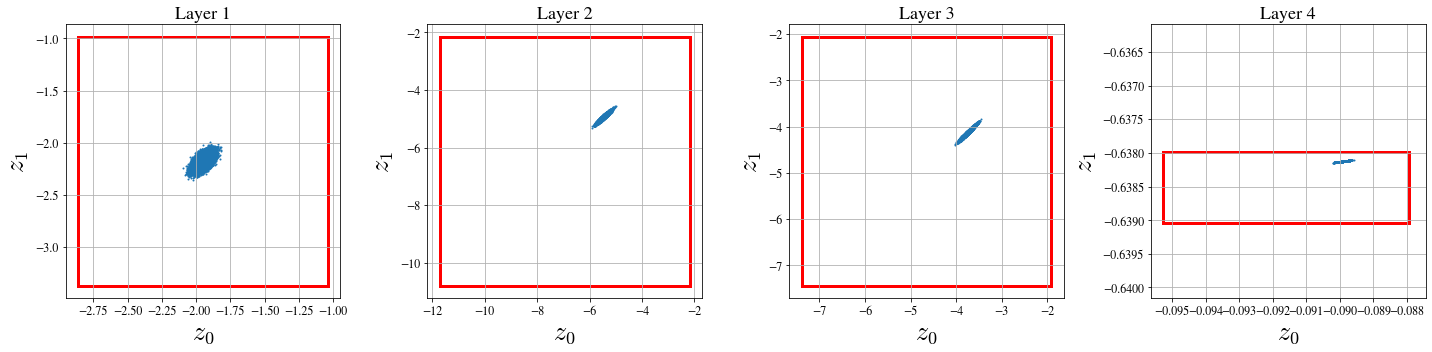

In [13]:
axis1 = 0
axis2 = 1

fig = plt.figure(figsize=(20, 5))

for i in range(4):
    ax = fig.add_subplot(1, 4, i + 1)
    z_ub = out[i][1].cpu().numpy()
    z_lb = out[i][2].cpu().numpy()
    z_0 = z[i][0].cpu().numpy()
    rc = Rectangle((z_lb[idx, axis1], z_lb[idx, axis2]), 
                   z_ub[idx, axis1] - z_lb[idx, axis1],
                   z_ub[idx, axis2] - z_lb[idx, axis2],
                   fill=False, color='r', lw=3)
    ax.add_patch(rc)
    plt.scatter(z_0[:, axis1], z_0[:, axis2], s=1)
    plt.grid(True)
    plt.xlabel(r'$z_0$', fontsize=26)
    plt.ylabel(r'$z_1$', fontsize=26)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.title('Layer %d' % (i + 1), fontsize=18)
    plt.tight_layout()
plt.savefig('ibp_l2_15_15.png', dpi=300, bbox_inches='tight')
plt.show()

In [122]:
eps = 0.2
x_tuple = get_input_bound(x_test.to(device), eps)

with torch.no_grad():
    out = net(x_tuple)
    diff = net.get_bound(x_tuple, y_test.to(device))

In [123]:
(diff >= 0).float().mean()

tensor(0.8972, device='cuda:0')

In [115]:
num = 50000
eps = 0.2
idx = 0

# l-inf
noise = torch.rand((num, 784)) * 2 - 1
x = (eps * noise).view(num, 1, 28, 28) + x_test[idx]
with torch.no_grad():
    sample_out = net((x.cuda(), None, None))

In [124]:
z_ub = out[1].cpu().numpy()
z_lb = out[2].cpu().numpy()
z = sample_out[0].cpu().numpy()

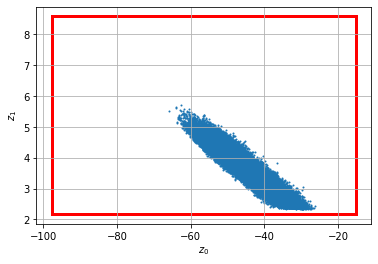

In [139]:
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

axis1 = 0
axis2 = 7

fig, ax = plt.subplots(1)
rc = Rectangle((z_lb[idx, axis1], z_lb[idx, axis2]), 
               z_ub[idx, axis1] - z_lb[idx, axis1],
               z_ub[idx, axis2] - z_lb[idx, axis2],
               fill=False, color='r', lw=3)
ax.add_patch(rc)
plt.scatter(z[:, axis1], z[:, axis2], s=1)
plt.grid(True)
plt.xlabel(r'$z_0$')
plt.ylabel(r'$z_1$')
plt.savefig('ibp_linf_2.png', dpi=300, bbox_inches='tight')
fig.show()

In [131]:
(x_test[0]/10).norm(p=float("inf"))

tensor(0.1000)

In [134]:
y_test[0]

tensor(7)

In [27]:
epss = np.arange(0, 3, 0.2)
accs = []

for exp in [8, 11, 12]:
    model_name = 'mnist_linf_ibp_exp%d.h5' % exp
    model_path = os.path.join(save_dir, model_name)
    net.load_state_dict(torch.load(model_path))
    
    acc = np.zeros(len(epss))

    for i, eps in enumerate(epss):
        params = {'p': 2,
                  'epsilon': eps,
                  'input_bound': (0, 1)}

        with torch.no_grad():
            diff = net.get_bound(x_test.cuda(), y_test.cuda(), params)

        acc[i] = (diff >= 0).float().mean().item()
    accs.append(acc)

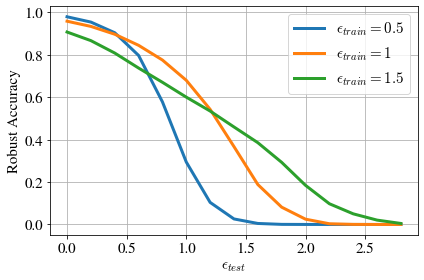

In [30]:
fs = 15
plt.plot(epss, accs[1], lw=3, label=r'$\epsilon_{train}=0.5$')
plt.plot(epss, accs[0], lw=3, label=r'$\epsilon_{train}=1$')
plt.plot(epss, accs[2], lw=3, label=r'$\epsilon_{train}=1.5$')
plt.xlabel(r'$\epsilon_{test}$', fontsize=fs)
plt.ylabel('Robust Accuracy', fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.legend(fontsize=fs)
plt.grid(True)
plt.tight_layout()
plt.savefig('ibp_l2_eps.png', dpi=300, bbox_inches='tight')
plt.show()